In [1]:
import os
import json
import pandas as pd
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from datetime import datetime as dt

In [2]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Load Data

In [3]:
DATASET = 'winogrande-m-option'
wd = os.path.dirname(os.path.abspath('__file__'))
f_name = f"{DATASET}_1.csv"

results = pd.read_csv(os.path.join(wd, f_name))

results = results.loc[results['dataset']==DATASET,:]

In [4]:
print(results)
print(results['best_val_accuracy'])

                 dataset framing  learning_rate  batch_size  max_epochs  \
121  winogrande-m-option  MC-MLM        0.00001          16          20   
122  winogrande-m-option  MC-MLM        0.00001          16          20   
123  winogrande-m-option  MC-MLM        0.00001          64          40   
124  winogrande-m-option  MC-MLM        0.00002          32          40   
125  winogrande-m-option  MC-MLM        0.00002          32          40   
..                   ...     ...            ...         ...         ...   
326  winogrande-m-option  P-SENT        0.00001           8          20   
327  winogrande-m-option  P-SENT        0.00002          16          20   
328  winogrande-m-option  P-SENT        0.00001          16          40   
329  winogrande-m-option  P-SENT        0.00002           8          40   
330  winogrande-m-option  P-SENT        0.00001          32          20   

       seed  best_val_accuracy  \
121  810635           0.694554   
122  769574           0.694554 

# Analyze

In [5]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

In [6]:
def make_box_plots(data,
                   labels, 
                   key_frame = 'framing',
                   key_acc = 'best_val_accuracy',
                   x_size = 15,
                   y_size = 5,
                   y_min = 55,
                   y_max = 100,
                   y_tick = 15,
                   y_offset = 1,
                   x_offset = .85,
                   splines_offset = 10,
                   bar_trans = 0.3,
                   colors = ['darkgrey',
                             'peachpuff',
                             'burlywood',
                             'gold',
                             'lightgreen',
                             'skyblue',
                             'plum',
                             'darkgrey'
                            ],
                   bar_colors = True,
                   bar_labels = True,
                   adjusted_axes = True,
                   title = None,
                   showfliers = True,
                   notch = False,
                   majority = None,
                   human = None,
                   ylabel = 'Accuracy (%)',
                   xlabel = 'Formalization',
                   label_size = 18,
                   tick_size = 12,
                   plabel_size = 12,
                   bar = False,
                   label_type = 'max',
                   box = True,
                   violin = False,
                  ):
    
    iter_labels = [x for x in labels]
    
    scores = {
        'all'    : [],
        'max'    : [],
        '3Q'     : [],
        'median' : [],
    }
    
    add_x_offset = {
        'max'    : 0,
        '3Q'     : 0.4,
        'median' : 0.45,
    }
    
    add_y_offset = {
        'max'    : 0,
        '3Q'     : -y_offset,
        'median' : -y_offset,
    }  
        
    for label in iter_labels:
        dist = data.loc[data[key_frame]==label,key_acc]*100
        scores['all'].append(sorted(dist.to_numpy()))
        scores['max'].append(max(dist))
        scores['3Q'].append(dist.quantile(q=0.75))
        scores['median'].append(dist.median())
    
    n_samples = len(scores['all'][0])
    
    # add majority class
    if not majority is None:
        labels.insert(0,'Majority')
        if bar:
            scores['all'].insert(0,[0])
        else:
            scores['all'].insert(0,[majority]*n_samples)
        
        for key, item in scores.items():
            if key != 'all':
                item.insert(0,majority)
    
    # add human results
    if not human is None:
        labels.append('Human')
        if bar:
            scores['all'].append([0])
        else:
            scores['all'].append([human]*n_samples)

        for key, item in scores.items():
            if key != 'all':
                item.append(human)
    
    
    # create figure
    fig, ax = plt.subplots(figsize=(x_size, y_size))
    
    # format chart
    if not title is None:
        ax.set_title(title)
    
    # format labels
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max+1, y_tick))
    ax.set_xticklabels(labels)
    ax.tick_params(labelsize=tick_size)
    
    if adjusted_axes:
        # Adjust plot borders
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position(('outward', splines_offset))
        ax.spines['bottom'].set_position(('outward', splines_offset))
    
    ticks = np.arange(len(labels))+1
    
    ax.set_ylabel(ylabel, fontsize=label_size)
    ax.set_xlabel(xlabel, fontsize=label_size)
    
    # make plots    
    assert label_type in scores.keys(), f"label_type {label_type} not supported"
    
    if bar:
        # bar chart
        if not bar_colors:
            colors = None
        ax.bar(ticks, scores[label_type], color = colors, alpha=bar_trans)
        
    if box:
        # box plot
        ax.boxplot(scores['all'], notch = notch, showfliers = showfliers)
        
    if violin:
        # violin plot
        ax.set_xticks(ticks)
        
        parts = ax.violinplot(scores['all'], positions = ticks, showmedians = False, showextrema=False)
        
        if bar_colors:
            for pc, color in zip(parts['bodies'], colors):
                pc.set_facecolor(color)
                pc.set_alpha(.5)
                pc.set_edgecolor('black')

        quartile1, medians, quartile3 = np.percentile(scores['all'], [25, 50, 75], axis=1)
        whiskers = np.array([
            adjacent_values(sorted_array, q1, q3)
            for sorted_array, q1, q3 in zip(scores['all'], quartile1, quartile3)])
        whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

        inds = np.arange(1, len(medians) + 1)
        ax.scatter(inds[1:len(inds)-1], medians[1:len(inds)-1], marker='_', color='orange', s=1000, zorder=3)
        ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
        ax.vlines(inds, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1)
                
    
    # add accuracy values
    if bar_labels:
        for i, v in enumerate(scores[label_type]):
            
            x=add_x_offset[label_type]
            y=add_y_offset[label_type]
            
            if ((not human is None and i == len(scores[label_type])-1)
                or (not majority is None and i == 0)):
                x = 0
                y = 0
                
            ax.text(i + x_offset + x,
                    v + y_offset + y,
                    "{:.2f}%".format(v),
                    fontsize=plabel_size,
                   )
    
    # Adjust layout
    fig.tight_layout()
    
    return fig

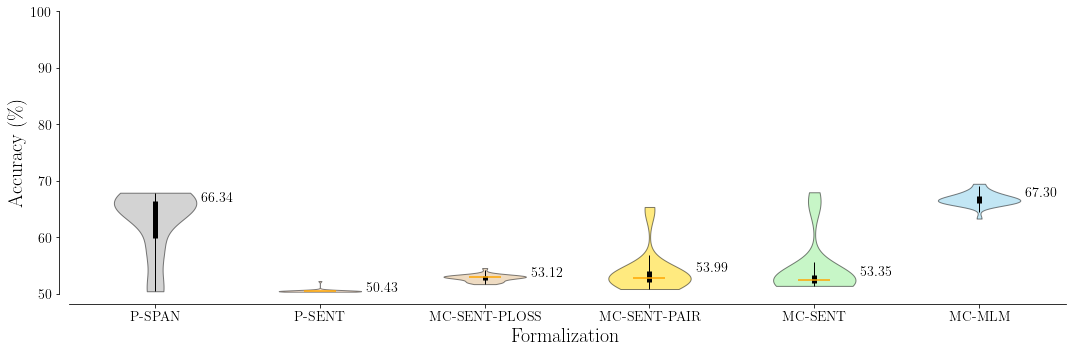

In [7]:
bar = False
box = False
violin = True

ordered_framings = ['P-SPAN',
                   'P-SENT',
                   'MC-SENT-PLOSS',
                   'MC-SENT-PAIR',
                   'MC-SENT',
                   'MC-MLM']

f_violin = make_box_plots(results,
                   ordered_framings,
                   adjusted_axes = True,
                   title = None,
                   showfliers = True,
                   y_min = 50,
                   y_max = 100,
                   y_tick = 10,
                   notch = False,
                   ylabel = r'Accuracy (\%)',
                   xlabel = r'Formalization',
                   majority = None,
                   human = None,
                   label_size=20,
                   tick_size=14,
                   plabel_size=14,
                   x_offset = .88,
                   bar_colors = True,
                   bar_labels = True,
                   label_type = '3Q',
                   bar = bar,
                   box = box,
                   violin = violin,
                  )

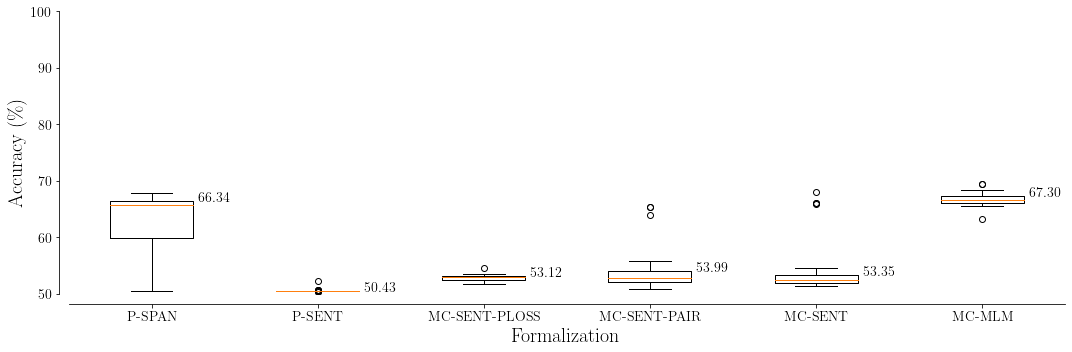

In [14]:
bar = False
box = True
violin = False

ordered_framings = ['P-SPAN',
                   'P-SENT',
                   'MC-SENT-PLOSS',
                   'MC-SENT-PAIR',
                   'MC-SENT',
                   'MC-MLM']

f_box = make_box_plots(results,
                   ordered_framings,
                   adjusted_axes = True,
                   title = None,
                   showfliers = True,
                   y_min = 50,
                   y_max = 100,
                   y_tick = 10,
                   notch = False,
                   ylabel = r'Accuracy (\%)',
                   xlabel = r'Formalization',
                   majority = None,
                   human = None,
                   label_size=20,
                   tick_size=14,
                   plabel_size=14,
                   x_offset = .88,
                   bar_colors = True,
                   bar_labels = True,
                   label_type = '3Q',
                   bar = bar,
                   box = box,
                   violin = violin,
                  )

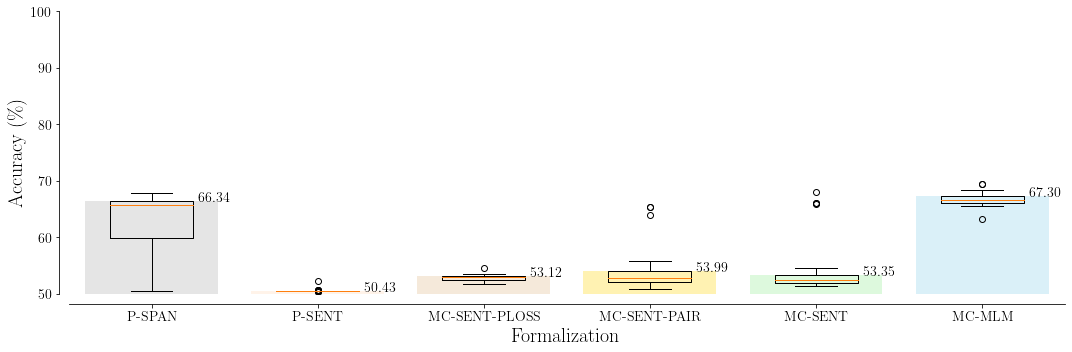

In [13]:
bar = True
box = True
violin = False

ordered_framings = ['P-SPAN',
                   'P-SENT',
                   'MC-SENT-PLOSS',
                   'MC-SENT-PAIR',
                   'MC-SENT',
                   'MC-MLM']

f_box_bar = make_box_plots(results,
                   ordered_framings,
                   adjusted_axes = True,
                   title = None,
                   showfliers = True,
                   y_min = 50,
                   y_max = 100,
                   y_tick = 10,
                   notch = False,
                   ylabel = r'Accuracy (\%)',
                   xlabel = r'Formalization',
                   majority = None,
                   human = None,
                   label_size=20,
                   tick_size=14,
                   plabel_size=14,
                   x_offset = .88,
                   bar_colors = True,
                   bar_labels = True,
                   label_type = '3Q',
                   bar = bar,
                   box = box,
                   violin = violin,
                  )

In [10]:
def get_stats(data,
              labels,
              key_frame = 'framing',
              key_acc = 'best_val_accuracy',
             ):
    results = {label : {} for label in labels}
    
    for label, value in results.items():
        dist = data.loc[data[key_frame]==label,key_acc]
        
        value['mean'] = dist.mean()
        value['std'] = dist.std()
        value['medium'] = dist.median()
        value['1Q'] = dist.quantile(q=0.25)
        value['3Q'] = dist.quantile(q=0.75)
        value['max'] = max(dist)
        value['min'] = min(dist)
    
    return results

In [11]:
ordered_framings = ['P-SPAN',
                   'P-SENT',
                   'MC-SENT-PLOSS',
                   'MC-SENT-PAIR',
                   'MC-SENT',
                   'MC-MLM']

stats = get_stats(results,
                  ordered_framings,
                 )

print(stats)

{'P-SPAN': {'mean': 0.6294133123215233, 'std': 0.05754861007479157, 'medium': 0.6562746646090013, '1Q': 0.5988555643545801, '3Q': 0.6633780584468462, 'max': 0.6787687451141315, 'min': 0.5043409629280208}, 'P-SENT': {'mean': 0.505130228911441, 'std': 0.003322813346678189, 'medium': 0.5043409629280208, '1Q': 0.5043409629280208, '3Q': 0.5043409629280208, 'max': 0.5224940805521742, 'min': 0.5035516969453846}, 'MC-SENT-PLOSS': {'mean': 0.5281241778706727, 'std': 0.0059668729105820965, 'medium': 0.5292028413928205, '1Q': 0.5240726124704026, '3Q': 0.5311760063611718, 'max': 0.5453827940251005, 'min': 0.5169692186266772}, 'MC-SENT-PAIR': {'mean': 0.5397000789509043, 'std': 0.0385187006986003, 'medium': 0.5272296764362301, '1Q': 0.5207182320677208, '3Q': 0.5398579321231255, 'max': 0.6535122336227308, 'min': 0.5082872928412016}, 'MC-SENT': {'mean': 0.5428308340239858, 'std': 0.049227146946898365, 'medium': 0.5248618784765606, '1Q': 0.5187450671287719, '3Q': 0.5335438043090802, 'max': 0.679558011

# Save Stuff

In [12]:
wd = os.path.dirname(os.path.abspath('__file__'))
now = dt.now().strftime("%Y%m%d_%H%M")

f = f_violin
f_type = 'violin'

plot_name = os.path.join(wd, 'plots', f"{DATASET}_plot_{f_type}_{now}.pdf")
stats_name = os.path.join(wd, 'stats', f"{DATASET}_stats_{now}.json")

f.savefig(plot_name)
with open(stats_name, 'w') as f:
    f.write(json.dumps(stats))